In [1]:
#import libraries
import pandas as pd #making dataframes
import geopandas as gpd #geospatial operations
from shapely.geometry import shape #making polygons
from sodapy import Socrata #api interface

We're pulling in data from the Socrata API (SODA) from the open data sites for both NY State and NYC.
The original analysis was done with all local files, but this will allow for web sharing.

In [2]:
#data inputs
client1 = Socrata("data.ny.gov", None)
client2 = Socrata("data.cityofnewyork.us", None)

#pull mta locations from api
mta_results = client1.get("39hk-dx4f", limit=2000)
mta_df = pd.DataFrame.from_records(mta_results)

#pull nyc public service locations from api
hospital_results = client2.get("67g2-p84d", limit=2000, facsubgrp="HOSPITALS AND CLINICS") #filtering to just medical facilities
hospital_df = pd.DataFrame.from_records(hospital_results)

#pull NYC borough boundaries from api
nyc_results = client2.get("7t3b-ywvw", limit=2000)
nyc_df = pd.DataFrame.from_records(nyc_results)


Now that we've ingested data as pandas dataframes, its time to set them up in a geospatial format using geopandas.

<Axes: >

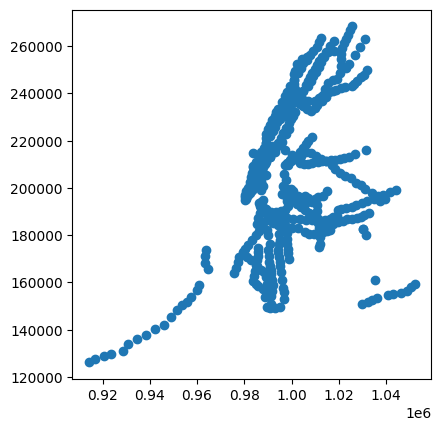

In [3]:
#mta gdf
mta_geometry = gpd.points_from_xy(mta_df['gtfs_longitude'], mta_df['gtfs_latitude'])
gdf_mta = gpd.GeoDataFrame(mta_df, geometry=mta_geometry, crs=4326) #geojson default is EPSG:4326

#converting CRS from WGS84 t0 NAD83 NY, Long Island (ft_us) for distance calculations
gdf_mta = gdf_mta.to_crs(epsg=2263)

#check map
gdf_mta.plot()

Looks good, I know the shape of NYC pretty well, so this aligns with the subway lines.

<Axes: >

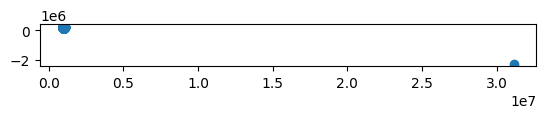

In [4]:
#hospitals gdf
hospital_geometry = gpd.points_from_xy(hospital_df['longitude'], hospital_df['latitude'])
gdf_hospitals = gpd.GeoDataFrame(hospital_df, geometry=hospital_geometry, crs=4326)
gdf_hospitals = gdf_hospitals.to_crs(epsg=2263)

#check map
gdf_hospitals.plot()

oh no! the hospitals data has a weird outlier (probably null island)

In [5]:
#sort hospitals dataframe to see if there's any 0,0 lat/longs
sorted_gdf_hospitals = gdf_hospitals.sort_values(by='geometry', ascending=False)
sorted_gdf_hospitals

,the_geom,facname,addressnum,streetname,address,city,zipcode,factype,facsubgrp,facgroup,...,nta2020,council,ct2010,ct2020,borocode,schooldist,policeprct,datasource,uid,geometry
619,NaN,SHOW BELLEUVE MOBILE VAN EXTENSION CLINIC 1,NaN,NaN,13-16 133RD STREET,NaN,11256,MOBILE HOSPITAL EXTENSION CLINIC,HOSPITALS AND CLINICS,HEALTH CARE,...,NaN,0,NaN,NaN,4,NaN,0,nysdoh_healthfacilities,8487b92ac419bc5d0e43e4950f92f7b5,POINT (31130726.733 -2280004.580)
78,"{'type': 'Point', 'coordinates': [-73.85266767...",ALBERT TUITT EDUCATIONAL ACADEMY,921,EAST 228 STREET,921 EAST 228 STREET,BRONX,10466,SCHOOL BASED DIAGNOSTIC AND TREATMENT CENTER E...,HOSPITALS AND CLINICS,HEALTH CARE,...,BX1201,12,040400,040400,2,11,47,nysdoh_healthfacilities,1b20686d2d2f9d4ee6d4c9d04e3cbc40,POINT (1024986.680 262914.726)
15,"{'type': 'Point', 'coordinates': [-73.84042830...",MIDDLE SCHOOL 142,3750,BAYCHESTER AVENUE,3750 BAYCHESTER AVENUE,BRONX,10466,SCHOOL BASED HOSPITAL EXTENSION CLINIC,HOSPITALS AND CLINICS,HEALTH CARE,...,BX1202,12,048400,048402,2,11,47,nysdoh_healthfacilities,057536200f35425f23a08958e45e7c17,POINT (1028372.203 262171.952)
490,"{'type': 'Point', 'coordinates': [-73.83215135...",BOSTON POST ROAD DIALYSIS CENTER,4000,BOSTON ROAD,4000 BOSTON ROAD,BRONX,10475,DIAGNOSTIC AND TREATMENT CENTER EXTENSION CLINIC,HOSPITALS AND CLINICS,HEALTH CARE,...,BX1202,12,046202,046209,2,11,47,nysdoh_healthfacilities,5671e54ede57dc94abc12b37547fa4f0,POINT (1030662.425 261343.963)
1009,"{'type': 'Point', 'coordinates': [-73.89155667...",P S 95,3961,HILLMAN AVENUE,3961 HILLMAN AVENUE,BRONX,10463,SCHOOL BASED HOSPITAL EXTENSION CLINIC,HOSPITALS AND CLINICS,HEALTH CARE,...,BX0801,11,028100,028100,2,10,50,nysdoh_healthfacilities,da3f72ffe59ed6fa450b2705a97aaf3a,POINT (1014236.266 261034.797)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,"{'type': 'Point', 'coordinates': [-74.13075562...","EGER HARBOR HOUSE, INC.",110,MEISNER AVENUE,110 MEISNER AVENUE,STATEN ISLAND,10306,ENRICHED HOUSING PROGRAM,HOSPITALS AND CLINICS,HEALTH CARE,...,SI0203,50,027900,027900,5,31,122,nysdoh_healthfacilities,0937704d8e0eca8b2788d3e87bb97a6b,POINT (947928.573 150785.955)
737,"{'type': 'Point', 'coordinates': [-74.10702015...",NEW DORP HIGH SCHOOL,465,NEW DORP LANE,465 NEW DORP LANE,STATEN ISLAND,10306,SCHOOL BASED HOSPITAL EXTENSION CLINIC,HOSPITALS AND CLINICS,HEALTH CARE,...,SI9592,50,011202,011204,5,31,122,nysdoh_healthfacilities,961ec29188754e57ecc7fa60da102611,POINT (954517.101 146963.914)
986,"{'type': 'Point', 'coordinates': [-74.10757041...",SUNRISE OF NEW DORP,470,NEW DORP LANE,470 NEW DORP LANE,STATEN ISLAND,10306,ENRICHED HOUSING PROGRAM,HOSPITALS AND CLINICS,HEALTH CARE,...,SI0202,50,012804,012804,5,31,122,nysdoh_healthfacilities,d4f1272efea64044a3ae3c2ac5d41609,POINT (954363.640 146486.498)
1088,"{'type': 'Point', 'coordinates': [-74.17614582...",STATEN ISLAND SOUTH DIALYSIS,30,SNEDEN AVENUE,30 SNEDEN AVENUE,STATEN ISLAND,10312,DIAGNOSTIC AND TREATMENT CENTER EXTENSION CLINIC,HOSPITALS AND CLINICS,HEALTH CARE,...,SI0304,51,017005,017005,5,31,123,nysdoh_healthfacilities,f16cf4241f4084abd04a58a3d43aa03b,POINT (935290.784 136184.153)


found it, "mobile clinic" was the issue, time to filter it out

<Axes: >

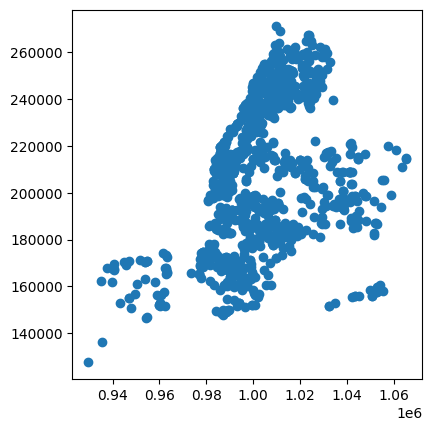

In [6]:
#get rid of null values
gdf_hospitals_cleaned = sorted_gdf_hospitals[~sorted_gdf_hospitals['the_geom'].isnull()]

#check the map again
gdf_hospitals_cleaned.plot()

looks good! Now to deal with the borough outlines. I had significant google help here, thank you stackoverflow!

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   the_geom    5 non-null      geometry
 1   boro_code   5 non-null      object  
 2   boro_name   5 non-null      object  
 3   shape_leng  5 non-null      object  
 4   shape_area  5 non-null      object  
 5   geometry    5 non-null      geometry
dtypes: geometry(2), object(4)
memory usage: 372.0+ bytes


,the_geom,boro_code,boro_name,shape_leng,shape_area,geometry
0,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...",5,Staten Island,325917.35395,1623620725.05,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...",1,Manhattan,357713.308162,636520502.758,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
2,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...",2,Bronx,463180.579449,1187174772.5,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
3,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ...",3,Brooklyn,728146.574928,1934138215.76,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
4,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ...",4,Queens,888199.731385,3041418506.64,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


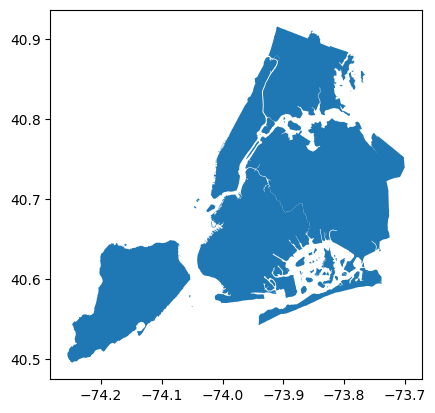

In [7]:
#establish 'the_geom' as a geometry type
for index, row in nyc_df.iterrows():
    row['the_geom'] = shape(row['the_geom'])
gdf_nyc = gpd.GeoDataFrame(nyc_df, geometry='the_geom', crs=4326)
gdf_nyc['geometry'] = gdf_nyc['the_geom']

#check work
gdf_nyc.plot()
gdf_nyc.info()
gdf_nyc.head()

Looks good! Time for some light geoprocessing

In [8]:
#limit MTA gdf to only include ada accessible stations
mta_ada = gdf_mta[gdf_mta['ada'] == '1']

<Axes: >

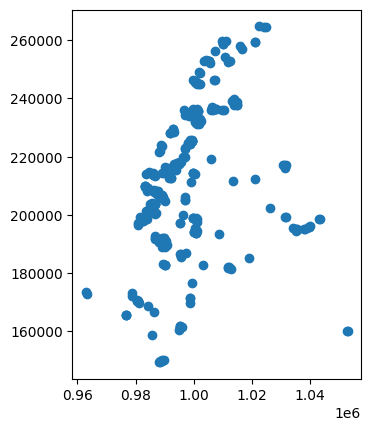

In [9]:
#join hospitals layer objects to nearest filtered mta layer objects
hospitals_join = gpd.sjoin_nearest(gdf_hospitals_cleaned,mta_ada, how='inner',distance_col="dist")

#dist field needs to be converted to integer for any computation
hospitals_join['dist_int'] = hospitals_join['dist'].astype(int)

#filter records <= .25 miles (1320 feet b/c crs is currently NAD83)
hospitals_accesible = hospitals_join[hospitals_join['dist_int'] <= 1320]
hospitals_accesible.plot()

We can see from above that once we filter out all hospitals outside a 1/4 mile radius, the number drops precipitously, this would indicate that the majority of hospitals aren't necessarily accessible to New Yorkers requiring ADA access in the subways. We can better illustrate this by plotting both sets of hospital layers together on a map.

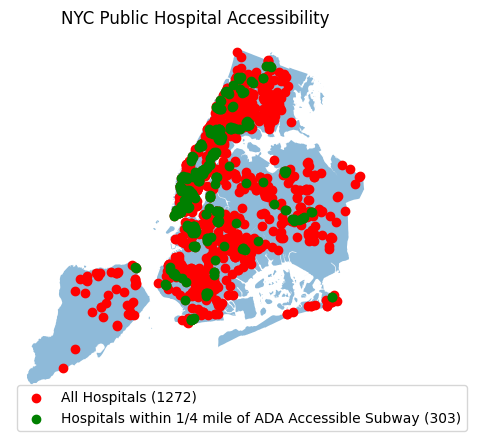

In [10]:
#remember to reproject back to EPSG:4326 for plotting
gdf_hospitals_cleaned = gdf_hospitals_cleaned.to_crs(4326)
hospitals_accesible = hospitals_accesible.to_crs(4326)

#nyc 'basemap'
ax = gdf_nyc.plot(alpha = 0.5, legend=True)

# calculate feature count dynamically (thanks again to stackoverflow)
#all hospitals
label_hosp = f"All Hospitals ({len(gdf_hospitals)})"  
gdf_hospitals_cleaned.plot(ax=ax, facecolor='r', label=label_hosp)

#accessible hospitals
label_acc = f"Hospitals within 1/4 mile of ADA Accessible Subway ({len(hospitals_accesible)})"
hospitals_accesible.plot(ax=ax, facecolor='g', label=label_acc)

#map settings
ax.set_title('NYC Public Hospital Accessibility')
ax.set_axis_off()
ax.legend(bbox_to_anchor=(0, -0.1),loc='lower left')

From the above, we can show that a little less than 25% of hospital and medical facilities in NYC are accessible by subway if you need to rely on ADA accessibility. This is obviously a weak spot in our infrastructure if we want to be a truely resilient city. I'll talk in more depth about this base analysis in a later post.